# Boundary Conditions for SPDEs

In previous tutorials, we saw that we can approximate stochastic processes
with GMRFs by discretizing stochastic partial differential equations (SPDEs).
Such discretizations always involve boundary conditions, which specify the
behavior of the process at the boundary of the domain.
In the context of the finite element method, the simplest boundary condition
is a homogeneous von Neumann boundary condition, which specifies that the
derivative of the process normal to the boundary is zero.
This approach is also used in the seminal work by Lindgren et al. [Lindgren2011](@cite).

Yet, in practice, this behavior is often not desirable.
To circumvent boundary effects, people often artificially inflate the domain
by adding a buffer zone around the data.

But what if we know the behavior of the process at the boundary, and it's
not "the normal derivative is zero"?
Fortunately, GaussianMarkovRandomFields.jl interfaces rather smoothly with Ferrite.jl, which we
can use to specify more complex boundary conditions. Let's see how this works.

## Spatial example: Matern SPDE
We start by specifying a mesh over the interval [-1, 1].

In [1]:
using GaussianMarkovRandomFields, Ferrite
grid = generate_grid(Line, (50,))
interpolation = Lagrange{RefLine,1}()
quadrature_rule = QuadratureRule{RefLine}(2)

QuadratureRule{RefLine, Vector{Float64}, Vector{Vec{1, Float64}}}([0.9999999999999998, 0.9999999999999998], Vec{1, Float64}[[-0.5773502691896257], [0.5773502691896257]])

### Dirichlet boundary
Let us now use Ferrite to define a homogeneous Dirichlet boundary condition,
which specifies that the process is zero at the boundary.

In [2]:
function get_dirichlet_constraint(grid::Ferrite.Grid{1})
    boundary = getfacetset(grid, "left") ∪ getfacetset(grid, "right")

    return Dirichlet(:u, boundary, x -> (x[1] ≈ -1.0) ? 0.0 : (x[1] ≈ 1.0) ? 0.0 : 0.0)
end

dbc = get_dirichlet_constraint(grid)

Dirichlet(Main.var"##237".var"#1#2"(), OrderedCollections.OrderedSet{FacetIndex}(FacetIndex[FacetIndex((1, 1)), FacetIndex((50, 2))]), :u, Int64[], Int64[], Int64[])

GaussianMarkovRandomFields.jl supports such boundary conditions in a "soft" way.
This means that we enforce the boundary conditions up to noise of a certain,
user-specified magnitude.
This ensures that the resulting GMRF has full rank.
If you don't care much for probabilistic boundary conditions, you can just
set the noise to a sufficiently small value.

In [3]:
bcs = [(dbc, 1e-4)] # 1e-4 is the noise in terms of the standard deviation

1-element Vector{Tuple{Dirichlet, Float64}}:
 (Dirichlet(Main.var"##237".var"#1#2"(), OrderedCollections.OrderedSet{FacetIndex}(FacetIndex[FacetIndex((1, 1)), FacetIndex((50, 2))]), :u, Int64[], Int64[], Int64[]), 0.0001)

We can now create a FEM discretization with the specified boundary conditions.

In [4]:
disc = FEMDiscretization(grid, interpolation, quadrature_rule, [(:u, nothing)], bcs)

FEMDiscretization
  grid: Grid{1, Line, Float64} with 50 Line cells and 51 nodes
  interpolation: Lagrange{RefLine, 1}()
  quadrature_rule: QuadratureRule{RefLine, Vector{Float64}, Vector{Vec{1, Float64}}}
  # constraints: 2


Let's now define some Matern SPDE and discretize it.

In [5]:
matern_spde = MaternSPDE{1}(range = 0.5, smoothness = 1, σ² = 0.3)
x = discretize(matern_spde, disc)

GMRF{Float64}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 51×51 LinearMapWithSqrt{Float64}
solver_ref: Base.RefValue{AbstractSolver}(CholeskySolver{TakahashiStrategy}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 51×51 LinearMapWithSqrt{Float64}, SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  150
nnz:     150
success: true
, TakahashiStrategy(), nothing, nothing))
)


Verify for yourself that the boundary value is zero for all samples, and that
the variance vanishes at the boundary:

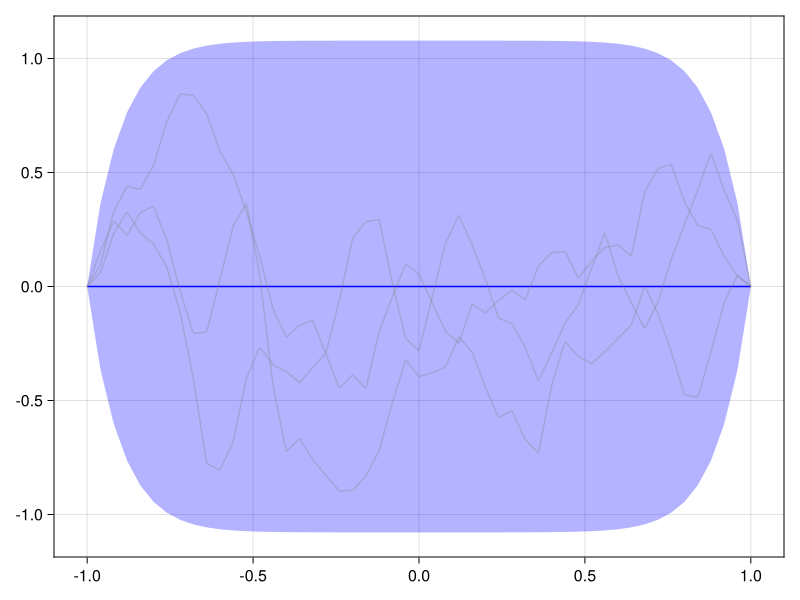

In [6]:
using CairoMakie
CairoMakie.activate!()
plot(x, disc)

### Periodic boundary
We can also define a periodic boundary condition in terms of an affine
constraint:

In [7]:
function get_periodic_constraint(grid::Ferrite.Grid{1})
    cellidx_left, dofidx_left = collect(grid.facetsets["left"])[1]
    cellidx_right, dofidx_right = collect(grid.facetsets["right"])[1]

    temp_dh = DofHandler(grid)
    add!(temp_dh, :u, Lagrange{RefLine,1}())
    close!(temp_dh)
    cc = CellCache(temp_dh)
    get_dof(cell_idx, dof_idx) = (reinit!(cc, cell_idx); celldofs(cc)[dof_idx])
    dof_left = get_dof(cellidx_left, dofidx_left)
    dof_right = get_dof(cellidx_right, dofidx_right)

    return AffineConstraint(dof_left, [dof_right => 1.0], 0.0)
end

pbc = get_periodic_constraint(grid)

AffineConstraint{Float64}(1, [51 => 1.0], 0.0)

The rest of the procedure is analogous to the Dirichlet case:

In [8]:
bcs = [(pbc, 1e-4)]
disc_periodic =
    FEMDiscretization(grid, interpolation, quadrature_rule, [(:u, nothing)], bcs)
x_periodic = discretize(matern_spde, disc_periodic)

GMRF{Float64}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 51×51 LinearMapWithSqrt{Float64}
solver_ref: Base.RefValue{AbstractSolver}(CholeskySolver{TakahashiStrategy}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 51×51 LinearMapWithSqrt{Float64}, SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  198
nnz:     198
success: true
, TakahashiStrategy(), nothing, nothing))
)


Verify for yourself that the values at the left and right boundary match
for all samples:

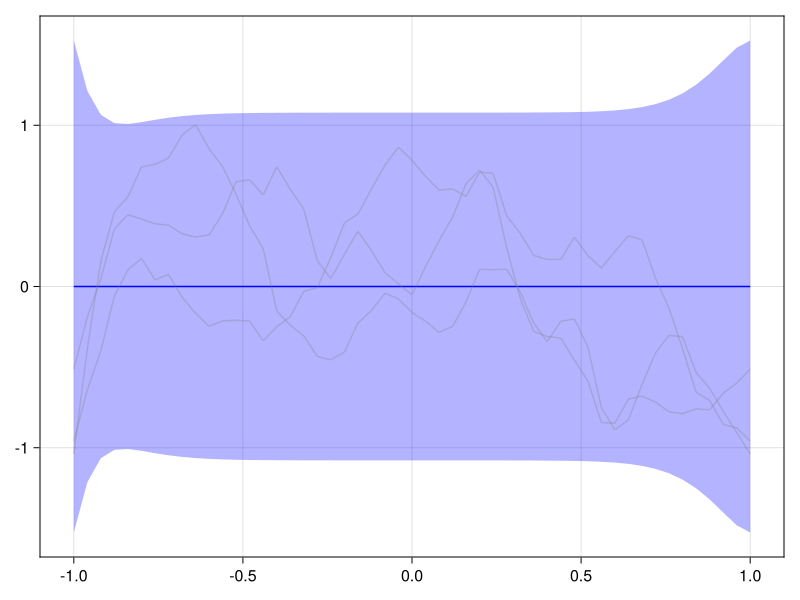

In [9]:
plot(x_periodic, disc)

## Spatiotemporal example: Advection-Diffusion SPDE
This works just as well in the spatiotemporal case.
Let's reuse our previous discretization for a 1D advection-diffusion SPDE:

In [10]:
using LinearAlgebra, SparseArrays
spde = AdvectionDiffusionSPDE{1}(
    γ = [-0.6],
    H = 0.1 * sparse(I, (1, 1)),
    τ = 0.1,
    α = 2 // 1,
    spatial_spde = matern_spde,
    initial_spde = matern_spde,
)
ts = 0:0.05:1
N_t = length(ts)
x_adv_diff_dirichlet = discretize(spde, disc, ts)
x_adv_diff_periodic = discretize(spde, disc_periodic, ts)

ImplicitEulerConstantMeshSTGMRF{1, Float64}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 1071×1071 LinearMapWithSqrt{Float64}
discretization: FEMDiscretization
  grid: Grid{1, Line, Float64} with 50 Line cells and 51 nodes
  interpolation: Lagrange{RefLine, 1}()
  quadrature_rule: QuadratureRule{RefLine, Vector{Float64}, Vector{Vec{1, Float64}}}
  # constraints: 1

ssm: ImplicitEulerSSM(GMRF{Float64}(
mean: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: 51×51 LinearMapWithSqrt{Float64}
solver_ref: Base.RefValue{AbstractSolver}(CholeskySolver{TakahashiStrategy}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 51×51 LinearMapWithSqrt{Float64}, SparseArrays.CHOLMOD.Factor{Float64, Int64}
type:    LLt
method:  simplicial
maxnnz:  198
nnz:     198
success: true
, TakahashiStrategy(), nothing, 

To make things clearer, we are going to condition these GMRFs on a Gaussian
initial condition to see how it propagates over time.

In [11]:
xs_ic = -0.99:0.01:0.99
ys_ic = exp.(-xs_ic .^ 2 / 0.2^2)
A_ic = evaluation_matrix(disc, [Tensors.Vec(x) for x in xs_ic])
A_ic = spatial_to_spatiotemporal(A_ic, 1, N_t)

x_adv_diff_dirichlet = condition_on_observations(x_adv_diff_dirichlet, A_ic, 1e8, ys_ic)
x_adv_diff_periodic = condition_on_observations(x_adv_diff_periodic, A_ic, 1e8, ys_ic)

LinearConditionalGMRF of size 1071 and solver LinearConditionalCholeskySolver{RBMCStrategy}

First, check the initial observations:

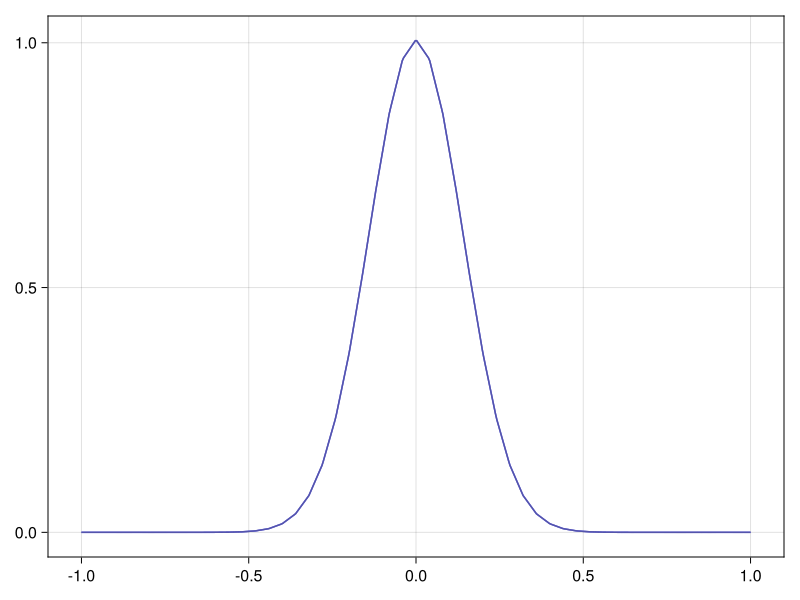

In [12]:
plot(x_adv_diff_dirichlet, 1)

Now, let's see how the process evolves over time:

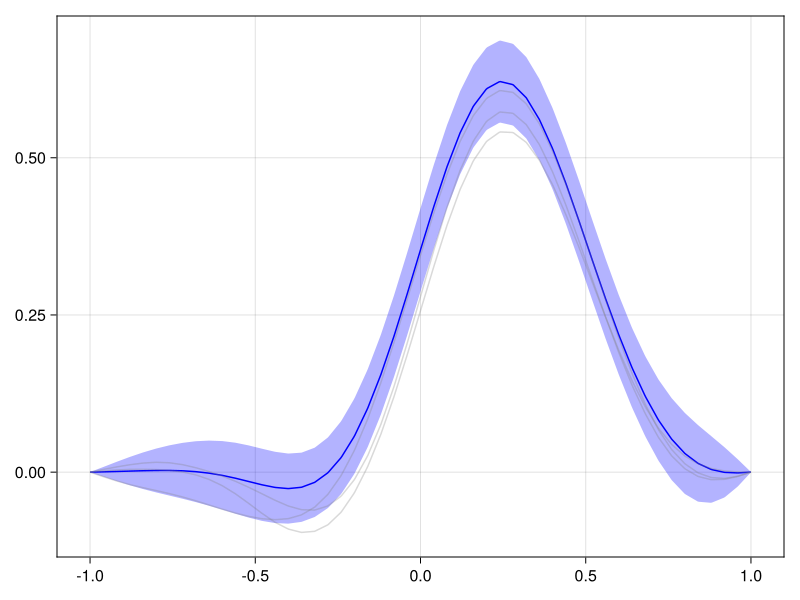

In [13]:
plot(x_adv_diff_dirichlet, N_t ÷ 2)

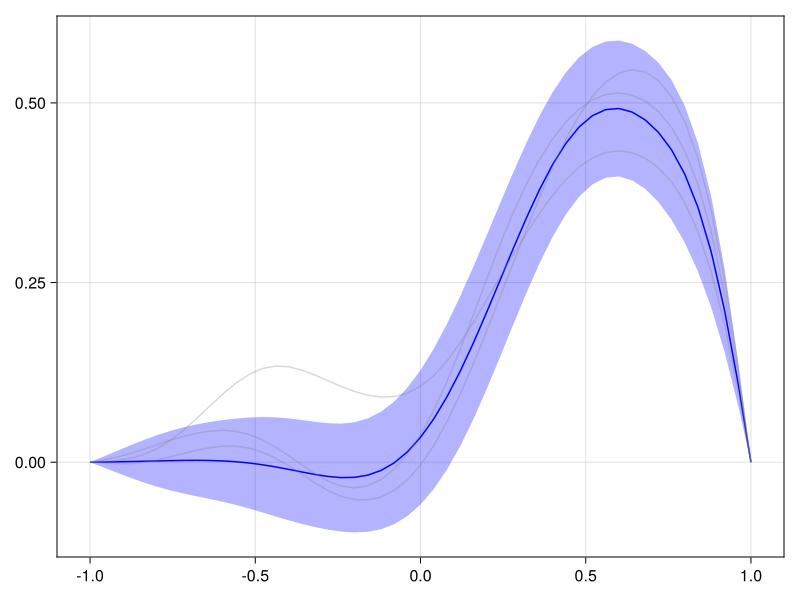

In [14]:
plot(x_adv_diff_dirichlet, N_t)

Compare to this to the periodic case:

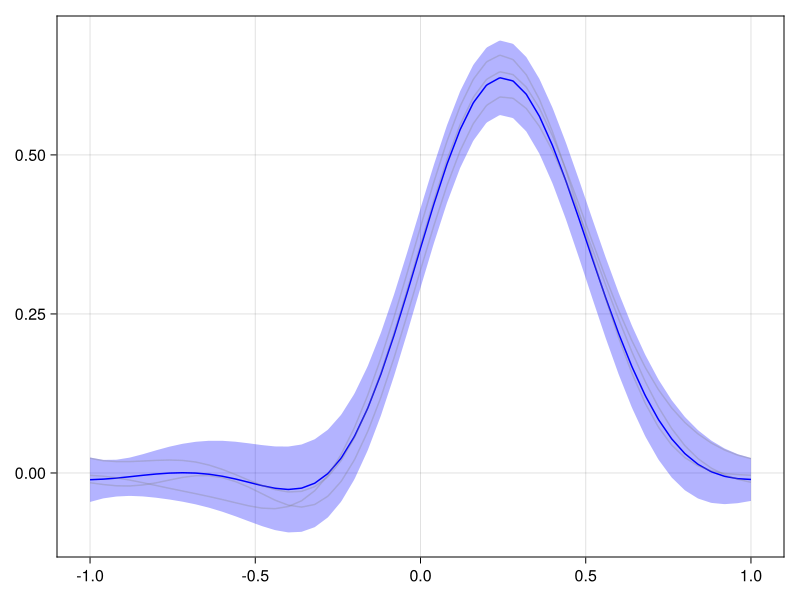

In [15]:
plot(x_adv_diff_periodic, N_t ÷ 2)

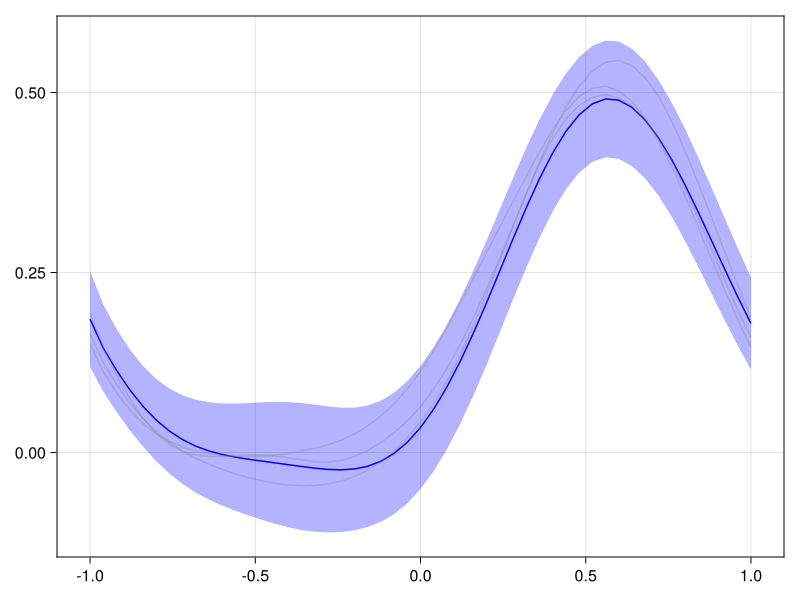

In [16]:
plot(x_adv_diff_periodic, N_t)

## Conclusion
We have seen how to specify more complex boundary conditions for GMRFs.
All it takes is to construct the boundary conditions in Ferrite and add
some noise.

For the sake of simplicity, this tutorial considered discretizations of
a one-dimensional interval, but of course the same principles apply to higher
dimensions and more complex geometries.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*